## NWB-Datajoint tutorial 1

**Note: make a copy of this notebook and run the copy to avoid git conflicts in the future**

This is the first in a multi-part tutorial on the NWB-Datajoint pipeline used in Loren Frank's lab, UCSF. It demonstrates how to run spike sorting within the pipeline.

If you have not done [tutorial 0](0_intro.ipynb) yet, make sure to do so before proceeding.

Let's start by importing the `nwb_datajoint` package, along with a few others. 

In [3]:
from pathlib import Path
import os
import numpy as np

import nwb_datajoint as nd

import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)  # ignore datajoint+jupyter async warning

# Comment these if you have already set these environment variables
data_dir = Path('/stelmo/nwb') # CHANGE ME TO THE BASE DIRECTORY FOR DATA STORAGE ON YOUR SYSTEM
os.environ['DJ_SUPPORT_FILEPATH_MANAGEMENT'] = 'TRUE'
os.environ['NWB_DATAJOINT_BASE_DIR'] = str(data_dir)
os.environ['KACHERY_STORAGE_DIR'] = str(data_dir / 'kachery-storage')
os.environ['SPIKE_SORTING_STORAGE_DIR'] = str(data_dir / 'spikesorting')

In [4]:
# We also import a bunch of tables so that we can call them easily
from nwb_datajoint.common import (RawPosition, HeadDir, Speed, LinPos, StateScriptFile, VideoFile,
                                  DataAcquisitionDevice, CameraDevice, Probe,
                                  DIOEvents,
                                  ElectrodeGroup, Electrode, Raw, SampleCount,
                                  LFPSelection, LFP, LFPBandSelection, LFPBand,
                                  SortGroup, SpikeSorting, SpikeSorter, SpikeSorterParameters, SpikeSortingWaveformParameters, SpikeSortingParameters, SpikeSortingMetrics, CuratedSpikeSorting,
                                  FirFilter,
                                  IntervalList, SortInterval,
                                  Lab, LabMember, Institution,
                                  BrainRegion,
                                  SensorData,
                                  Session, ExperimenterList,
                                  Subject,
                                  Task, TaskEpoch,
                                  Nwbfile, AnalysisNwbfile, NwbfileKachery, AnalysisNwbfileKachery)

In this tutorial, we will continue to work with the copy of `beans20190718.nwb` that you created in tutorial 0. If you deleted it from `Session`, make sure to re-insert before proceeding.

In [5]:
# Define the name of the file that you copied and renamed; make sure it's something unique. 
nwb_file_name = 'despereaux20191125_.nwb'

In [6]:
Nwbfile()

nwb_file_name name of the NWB file,nwb_file_abs_path
beans20190718_jhbak_.nwb,=BLOB=
despereaux20191125_2_.nwb,=BLOB=
despereaux20191125_.nwb,=BLOB=
senor20201030_.nwb,=BLOB=
beans20190718_.nwb,=BLOB=
beans20190718_jhbak2_.nwb,=BLOB=
peanut20201117_.nwb,=BLOB=
kf220170120_test2_.nwb,=BLOB=
kf220170120_test_.nwb,=BLOB=


### Spike sorting

In general, running spike sorting means making decisions about the following:
1. which eletrodes to sort together (e.g. electrodes that form a tetrode should be sorted together, but tetrodes that are far apart need not be);
2. which time interval to sort (e.g. there may a long period in the recording where nothing happens, and we might want to exclude that);
3. which spike sorter to use (e.g. Mountainsort? Kilosort? IronClust?);
4. given choice of the spike sorter in 3, which parameter set to use.

In our Datajoint framework, everything that we do is an interaction with a table. This is true for spike sorting as well - i.e. we think of spike sorting as a process where we enter parameters of spike sorting (i.e. our decisions about the four questions above) into tables, and use that information to populate another table that will hold the result of spike sorting. Under the hood, we use a number of packages, notably `spikeinterface`. But the user need not know this - they just have to interact with the table. This makes spike sorting straightforward. In addition, the entries in these tables serve as a record of exactly which decisions you made.

#### Define sort group
We start with the first question: which electrodes do we want to sort together? We first inspect the `Electrode` table.

This recording was done with polymer probes. Here `electrode_group_name` refers to a probe. We can see that there were two probes, `0` and `1`.

In [7]:
# get unique probe id
np.unique((Electrode & {'nwb_file_name': nwb_file_name}).fetch('electrode_group_name'))

array(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28',
       '29', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [8]:
sort_group_id = 10

Note that `insert` is a method, just like `fetch`. You can insert an entry in the form of a dictionary or a list in the order of the attributes. We can look at the new entries we just made.

In [10]:
Electrode() & {'nwb_file_name' : nwb_file_name}

nwb_file_name name of the NWB file,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode,probe_type,probe_shank shank number within probe,probe_electrode electrode,region_id,name unique label for each contact,original_reference_electrode the configured reference electrode for this electrode,x the x coordinate of the electrode position in the brain,y the y coordinate of the electrode position in the brain,z the z coordinate of the electrode position in the brain,filtering description of the signal filtering,impedance electrode impedance,bad_channel if electrode is 'good' or 'bad' as observed during recording,x_warped x coordinate of electrode position warped to common template brain,y_warped y coordinate of electrode position warped to common template brain,z_warped z coordinate of electrode position warped to common template brain,contacts label of electrode contacts used for a bipolar signal -- current workaround
despereaux20191125_.nwb,0,0,tetrode_12.5,0,0,3,0,-1,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
despereaux20191125_.nwb,0,1,tetrode_12.5,0,1,3,1,-1,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
despereaux20191125_.nwb,0,2,tetrode_12.5,0,2,3,2,-1,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
despereaux20191125_.nwb,0,3,tetrode_12.5,0,3,3,3,-1,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
despereaux20191125_.nwb,1,4,tetrode_12.5,0,0,2,4,-1,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
despereaux20191125_.nwb,1,5,tetrode_12.5,0,1,2,5,-1,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
despereaux20191125_.nwb,1,6,tetrode_12.5,0,2,2,6,-1,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
despereaux20191125_.nwb,1,7,tetrode_12.5,0,3,2,7,-1,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
despereaux20191125_.nwb,10,40,tetrode_12.5,0,0,2,40,-1,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
despereaux20191125_.nwb,10,41,tetrode_12.5,0,1,2,41,-1,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,


In [9]:
SortGroup & {'nwb_file_name' : nwb_file_name, 'sort_group_id' : sort_group_id}

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,"sort_reference_electrode_id the electrode to use for reference. -1: no reference, -2: common median"
despereaux20191125_.nwb,10,-1


In [71]:
SortGroup.SortGroupElectrode & {'nwb_file_name': nwb_file_name, 'sort_group_id': sort_group_id}

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode
despereaux20191125_.nwb,10,18,72
despereaux20191125_.nwb,10,18,73
despereaux20191125_.nwb,10,18,74
despereaux20191125_.nwb,10,18,75


#### Define sort interval
Next, we make a decision about the time interval for our spike sorting. Let's re-examine `IntervalList`.

In [72]:
interval_list_name = '02_r1'
sort_interval_name = '02_r1'

In [74]:
sorter_name='mountainsort4'

#### Define sorter parameters
Once we have decided on a spike sorter, we have to set parameters. Some of these parameters are common to all sorters (e.g. frequency band to filter the raw data before sorting begins) but most are specific to the sorter that we chose. Again, we populate `SpikeSorterParameters` table with some default parameters for each sorter, and then we add our version as a new entry.

In [92]:
# Let's look at the default params
ms4_default_params = (SpikeSorterParameters & {'sorter_name' : sorter_name,
                                               'parameter_set_name' : 'default'}).fetch1()
print(ms4_default_params)

{'sorter_name': 'mountainsort4', 'parameter_set_name': 'default', 'parameter_dict': {'detect_sign': -1, 'adjacency_radius': -1, 'freq_min': 300, 'freq_max': 6000, 'filter': True, 'whiten': True, 'curation': False, 'num_workers': None, 'clip_size': 50, 'detect_threshold': 3, 'detect_interval': 10, 'noise_overlap_threshold': 0.15}, 'frequency_min': 300, 'frequency_max': 6000, 'filter_width': 1000, 'filter_chunk_size': 30000}


In [102]:
# Change the default params
param_dict = ms4_default_params['parameter_dict']
param_dict['adjacency_radius'] = 100
param_dict['curation'] = False
# Turn filter and whiten off since we will filter it prior to starting sort
param_dict['filter'] = False
param_dict['whiten'] = False
# set num_workers to be the same number as the number of electrodes
param_dict['num_workers'] = len((SortGroup.SortGroupElectrode & {'nwb_file_name': nwb_file_name,'sort_group_id':sort_group_id}).fetch('electrode_id'))
param_dict['verbose'] = True
# set clip size as number of samples for 2 milliseconds
param_dict['clip_size'] = np.int(1e-3 * (Raw & {'nwb_file_name' : nwb_file_name}).fetch1('sampling_rate'))
param_dict['noise_overlap_threshold'] = 0

In [103]:
param_dict

{'detect_sign': -1,
 'adjacency_radius': 100,
 'freq_min': 300,
 'freq_max': 6000,
 'filter': False,
 'whiten': False,
 'curation': False,
 'num_workers': 4,
 'clip_size': 30,
 'detect_threshold': 3,
 'detect_interval': 10,
 'noise_overlap_threshold': 0,
 'verbose': True}

In [104]:
# Give a unique name here
parameter_set_name = 'franklab_hippocampus_test2'

In [105]:
SpikeSorterParameters() & {'sorter_name': 'mountainsort4'}

sorter_name the name of the spike sorting algorithm,parameter_set_name label for this set of parameters,parameter_dict dictionary of parameter names and values,frequency_min high pass filter value,frequency_max low pass filter value,filter_width the number of coefficients in the filter,filter_chunk_size the size of the chunk for the filtering
mountainsort4,beans_ms4,=BLOB=,300,6000,1000,2000000
mountainsort4,default,=BLOB=,300,6000,1000,30000
mountainsort4,franklab_hippocampus_test,=BLOB=,300,6000,1000,30000
mountainsort4,franklab_hippocampus_test2,=BLOB=,600,6000,1000,2000000
mountainsort4,kftest,=BLOB=,600,6000,1000,30000
mountainsort4,kftest7,=BLOB=,600,6000,1000,30000
mountainsort4,kftet,=BLOB=,300,6000,1000,30000
mountainsort4,kftet1,=BLOB=,300,6000,1000,30000
mountainsort4,kftet2,=BLOB=,600,6000,1000,30000
mountainsort4,kftet3,=BLOB=,600,6000,1000,30000


In [106]:
# Insert
(SpikeSorterParameters() & {'sorter_name' : sorter_name,
                               'parameter_set_name' : parameter_set_name}).delete()
SpikeSorterParameters.insert1({'sorter_name' : sorter_name,
                               'parameter_set_name' : parameter_set_name,
                               'parameter_dict' : param_dict,
                               'frequency_min':600,
                                'filter_chunk_size' : 2000000})

About to delete:
`common_spikesorting`.`spike_sorter_parameters`: 1 items


Proceed? [yes, No]:  yes


Committed.


{'detect_sign': -1,
 'adjacency_radius': 100,
 'freq_min': 300,
 'freq_max': 6000,
 'filter': False,
 'whiten': False,
 'curation': False,
 'num_workers': 4,
 'clip_size': 30,
 'detect_threshold': 3,
 'detect_interval': 10,
 'noise_overlap_threshold': 0,
 'verbose': True}

In [107]:
# Check that insert was successful
SpikeSorterParameters & {'sorter_name' : sorter_name, 'parameter_set_name' : parameter_set_name}

sorter_name the name of the spike sorting algorithm,parameter_set_name label for this set of parameters,parameter_dict dictionary of parameter names and values,frequency_min high pass filter value,frequency_max low pass filter value,filter_width the number of coefficients in the filter,filter_chunk_size the size of the chunk for the filtering
mountainsort4,franklab_hippocampus_test2,=BLOB=,600,6000,1000,2000000


#### Define qualtiy metric parameters

We're almost done. There are more parameters related to how to compute the quality metrics for curation. We just use the default options here. 

In [108]:
# we'll use `test`
SpikeSortingMetrics()

cluster_metrics_list_name the name for this list of cluster metrics,metrics_dict a dict of SpikeInterface metrics with True / False elements to indicate whether a given metric should be computed.,isi_threshold Interspike interval threshold in s for ISI metric (default 0.003),snr_mode SNR mode: median absolute deviation ('mad) or standard deviation ('std') (default 'mad'),snr_noise_duration length of data to use for noise estimation (default 10.0),max_spikes_per_unit_for_snr Maximum number of spikes to compute templates for SNR from (default 1000),template_mode Use 'mean' or 'median' to compute templates,"max_channel_peak direction of the maximum channel peak: 'both', 'neg', or 'pos' (default 'both')",max_spikes_per_unit_for_noise_overlap Maximum number of spikes to compute templates for noise overlap from (default 1000),noise_overlap_num_features Number of features to use for PCA for noise overlap,noise_overlap_num_knn Number of nearest neighbors for noise overlap,drift_metrics_interval_s length of period in s for evaluating drift (default 60 s),drift_metrics_min_spikes_per_interval minimum number of spikes in an interval for evaluation of drift (default 10),max_spikes_for_silhouette Max spikes to be used for silhouette metric,num_channels_to_compare number of channels to be used for the PC extraction and comparison (default 7),max_spikes_per_cluster Max spikes to be used from each unit,max_spikes_for_nn Max spikes to be used for nearest-neighbors calculation,n_neighbors number of nearest clusters to use for nearest neighbor calculation (default 4),n_jobs Number of parallel jobs (default 96),"memmap If True, waveforms are saved as memmap object (recommended for long recordings with many channels)",max_spikes_per_unit Max spikes to use for computing waveform,seed Random seed for reproducibility,"verbose If nonzero (True), will be verbose in metric computation"
default,=BLOB=,0.003,mad,10.0,500,mean,both,500,5,1,60.0,10,500,7,500,500,1,64,0,2000,47,1
default_n_jobs_4,=BLOB=,0.003,mad,10.0,500,mean,both,500,5,1,60.0,10,500,7,500,500,1,4,0,2000,47,1
franklab_default,=BLOB=,0.003,mad,10.0,1000,mean,both,1000,5,1000,60.0,10,1000,7,1000,1000,4,96,0,2000,47,1
kftest,=BLOB=,0.003,mad,10.0,500,mean,both,500,5,100,60.0,10,1000,7,500,500,4,1,0,2000,47,1
kftest7,=BLOB=,0.003,mad,10.0,500,mean,both,500,5,100,60.0,10,500,7,500,500,4,8,0,2000,47,1
kftet,=BLOB=,0.003,mad,10.0,1000,mean,both,1000,5,1000,60.0,10,1000,7,1000,1000,4,1,0,2000,47,1
kftet1,=BLOB=,0.003,mad,10.0,1000,mean,both,500,5,1,60.0,10,1000,7,1000,500,1,1,0,2000,47,1
kftet2,=BLOB=,0.003,mad,10.0,1000,mean,both,500,5,1,60.0,10,1000,7,1000,500,4,1,0,2000,47,1
kftet3,=BLOB=,0.003,mad,10.0,1000,mean,both,500,5,1,60.0,10,1000,7,1000,500,4,1,0,2000,47,1
test,=BLOB=,0.003,mad,10.0,1000,mean,both,100,3,10,60.0,10,1000,7,1000,1000,4,1,0,2000,47,1


In [264]:
SpikeSortingParameters().drop()

`common_spikesorting`.`spike_sorting_parameters` (151 tuples)
`common_spikesorting`.`__spike_sorting` (77 tuples)
`common_spikesorting`.`__curated_spike_sorting` (0 tuples)
`common_spikesorting`.`__curated_spike_sorting__units` (0 tuples)


Proceed? [yes, No]:  yes


Tables dropped.  Restart kernel.


#### Bringing everything together

We now collect all the decisions we made up to here and put it into `SpikeSortingParameters` table (note: this is different from spike sor*ter* parameters defined above).

In [109]:
# collect the params
key = dict()
key['nwb_file_name'] = nwb_file_name
key['sort_group_id'] = sort_group_id
key['sort_interval_name'] = sort_interval_name
key['interval_list_name'] = interval_list_name
key['sorter_name'] = sorter_name
key['parameter_set_name'] = parameter_set_name
key['cluster_metrics_list_name'] = cluster_metrics_list_name

In [110]:
# insert
SpikeSortingParameters.insert1(key, skip_duplicates = True)

In [112]:
# inspect
(SpikeSortingParameters & {'nwb_file_name' : nwb_file_name, 'parameter_set_name': 'franklab_hippocampus_test2'}).fetch1()

{'nwb_file_name': 'despereaux20191125_.nwb',
 'sort_group_id': 10,
 'sorter_name': 'mountainsort4',
 'parameter_set_name': 'franklab_hippocampus_test2',
 'sort_interval_name': '02_r1',
 'cluster_metrics_list_name': 'test',
 'interval_list_name': '02_r1',
 'import_path': ''}

In [113]:
recording = SpikeSorting().get_filtered_recording_extractor(key)

/home/loren/anaconda3/envs/nwb_datajoint/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/raw/despereaux20191125_.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)


Tetrode; making up channel locations...


In [242]:
data = recording.get_traces()

In [142]:
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
data.shape

(4, 164479040)

In [262]:
IntervalList()

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,valid_times numpy array with start and end times for each interval
beans20190718_.nwb,01_s1,=BLOB=
beans20190718_.nwb,02_r1,=BLOB=
beans20190718_.nwb,03_s2,=BLOB=
beans20190718_.nwb,04_r2,=BLOB=
beans20190718_.nwb,pos 0 valid times,=BLOB=
beans20190718_.nwb,pos 1 valid times,=BLOB=
beans20190718_.nwb,pos 2 valid times,=BLOB=
beans20190718_.nwb,pos 3 valid times,=BLOB=
beans20190718_.nwb,raw data valid times,=BLOB=
beans20190718_jhbak2_.nwb,01_s1,=BLOB=


In [244]:
zscore_thresh = 10
amplitude_thresh = 3000

In [245]:
above_z = zscore > zscore_thresh
above_a = data > amplitude_thresh

In [246]:
above_both = np.ravel(np.argwhere(np.sum(np.logical_and(above_z, above_a), axis=0) > 3))

In [247]:
def crossings_pos2neg(data):
    pos = data > 0
    return (pos[:-1] & ~pos[1:]).nonzero()[0]

def crossings_neg2pos(data):
    pos = data > 0
    return (~pos[:,-1] & pos[1:]).nonzero()[0]

In [257]:
recording.get_num_frames


Signature: st.preprocessing.mask(recording, bool_mask)
Docstring:
Apply a boolean mask to the recording, where False elements of the mask cause the associated recording frames to
be set to 0

Parameters
----------
recording: RecordingExtractor
    The recording extractor to be transformed
bool_mask: list or numpy array
    Boolean values of the same length as the recording

Returns
-------
masked_traces: MaskTracesRecording
    The masked traces recording extractor object
File:      ~/anaconda3/envs/nwb_datajoint/lib/python3.8/site-packages/spiketoolkit/preprocessing/mask.py
Type:      function


In [250]:
zero_size = 30
for a in above_both:
    data[:, a-zero_size:a+zero_size] = 0

In [255]:
recording._timestamps

array([1.57470781e+09, 1.57470781e+09, 1.57470781e+09, ...,
       1.57471329e+09, 1.57471329e+09, 1.57471329e+09])

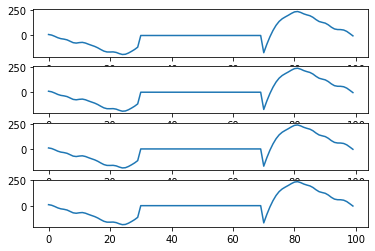

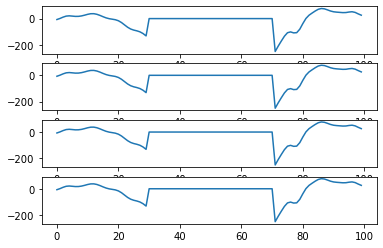

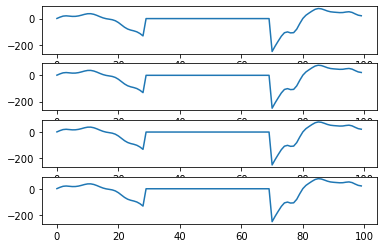

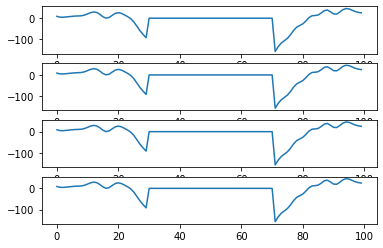

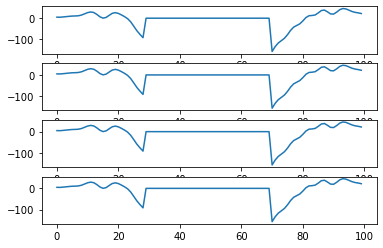

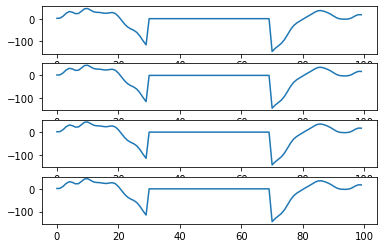

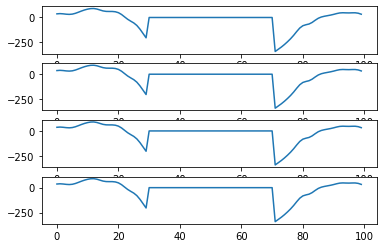

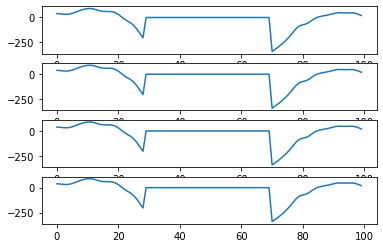

In [251]:

w = 50
for a in above_both:
    plt.figure()
    for e in range(4):
        plt.subplot(4,1,e+1)
        plt.plot(data[3, a-w:a+w])
        

In [204]:
vcounter=1;
ofc_filelist={'nt31.mda', 'nt32.mda', 'nt33.mda', 'nt34.mda', 'nt35.mda', 'nt36.mda', 'nt37.mda', 'nt39.mda', 'nt40.mda', 'nt41.mda', 'nt42.mda', 'nt43.mda', 'nt46.mda'};
%ofc_filelist={'nt31.mda', 'nt32.mda', 'nt33.mda', 'nt34.mda', 'nt36.mda', 'nt39.mda', 'nt40.mda', 'nt41.mda', 'nt42.mda', 'nt43.mda'};
hpc_filelist={'nt5.mda','nt6.mda'}; %HPC
%hpc_filelist={'nt5.mda','nt6.mda'}; %HPC
pfc_filelist={'nt15.mda','nt16.mda','nt17.mda','nt18.mda','nt23.mda','nt24.mda','nt25.mda','nt26.mda'}; %PFC
%pfc_filelist={'nt16.mda','nt17.mda','nt18.mda','nt23.mda','nt24.mda','nt25.mda','nt26.mda'}; %PFC
nacc_filelist={'nt47.mda','nt48.mda','nt49.mda','nt50.mda','nt51.mda','nt52.mda','nt53.mda','nt54.mda','nt55.mda','nt56.mda','nt57.mda','nt58.mda','nt60.mda'};
%nacc_filelist={'nt47.mda','nt48.mda','nt49.mda','nt50.mda','nt53.mda','nt55.mda','nt57.mda','nt58.mda','nt60.mda'};
z

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

#### Running spike sorting
Now we can run spike sorting. As we said it's nothing more than populating another table (`SpikeSorting`) from the entries of `SpikeSortingParameters`.

In [28]:
SpikeSorting.populate((SpikeSortingParameters & {'nwb_file_name' : nwb_file_name, 'parameter_set_name' : 'franklab_hippocampus_test'}).proj())

Getting ready...


/home/loren/anaconda3/envs/nwb_datajoint/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/despereaux20191125_000000.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/loren/anaconda3/envs/nwb_datajoint/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/despereaux20191125_000001.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/loren/anaconda3/envs/nwb_datajoint/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/despereaux20191125_000002.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/loren/anaconda3/envs/nwb_datajoint/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/ana

Writing new NWB file despereaux20191125_000030.nwb


/home/loren/anaconda3/envs/nwb_datajoint/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/raw/despereaux20191125_.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)


Tetrode; making up channel locations...


DataJointError: Attribute `artifact_param_name` is not found

In [1]:
import spiketoolkit as st
st.preprocessing.bandpass_filter?

Signature:
st.preprocessing.bandpass_filter(
    recording,
    freq_min=300,
    freq_max=6000,
    freq_wid=1000,
    filter_type='fft',
    order=3,
    chunk_size=30000,
    cache_chunks=False,
    dtype=None,
)
Docstring:
Performs a lazy filter on the recording extractor traces.

Parameters
----------
recording: RecordingExtractor
    The recording extractor to be filtered.
freq_min: int or float
    High-pass cutoff frequency.
freq_max: int or float
    Low-pass cutoff frequency.
freq_wid: int or float
    Width of the filter (when type is 'fft').
filter_type: str
    'fft' or 'butter'. The 'fft' filter uses a kernel in the frequency domain. The 'butter' filter uses
    scipy butter and filtfilt functions.
order: int
    Order of the filter (if 'butter').
chunk_size: int
    The chunk size to be used for the filtering.
cache_chunks: bool (default False).
    If True then each chunk is cached in memory (in a dict)
dtype: dtype
    The dtype of the traces

Returns
-------
filter_re